In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import graphviz
import pygraphviz
import math
import simpy
import random
from collections import namedtuple
from contextlib import ExitStack
from numpy import inf
import itertools

from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
import matplotlib
# get_ipython().run_line_magic('matplotlib', 'inline')
from matplotlib.gridspec import GridSpec
matplotlib.pyplot.style.use('seaborn-darkgrid')
import tkinter as tk
from tkinter import ttk
import datetime
from datetime import timedelta as td
from datetime import time as dtt
import warnings
warnings.filterwarnings("ignore")
import time
import mplcursors



In [2]:

# In[2]:


# Global Variables

# Import the Line Details from Base File and Create Base Data
# Nhập dữ liệu cơ sở và tạo dữ liệu cơ sở
file_path = r'Line Balancing.xlsm'

# For Capturing the Production During Simulation
# Bắt giữ các sản phẩm trong quá trình mô phỏng
throughput = 0

# Que as Raw Material in Production
# Que là nguyên liệu thô trong sản xuất
Que = namedtuple('Que','RM_id, Task, Task_Time, End_Time, Next_Task')

# List of All Global Variables
# Danh sách các biến số toàn cầu
production = globals()

# Get Color List for Network
# Lấy danh sách các màu cho mạng
node_colors = pd.read_excel(file_path, sheet_name='Colors',usecols='A,C')
node_colors = node_colors['Hex'].to_dict()


# Get Input Numbers for Line Balancing and Simulation
# Lấy số liệu cân bằng và mô phỏng
input_data = pd.read_excel(file_path, sheet_name='Input_Data_5',skiprows=3,usecols='B:C')
cycle_time = input_data[input_data['Particulars'] == 'Cycle Time (Max of Takt Time Vs Bottleneck)']['Input'].tolist()[0]
workstations = input_data[input_data['Particulars'] == 'Max Number of Workstations']['Input'].tolist()[0]
takt_time = input_data[input_data['Particulars'] == 'Takt Time Desired in Minutes']['Input'].tolist()[0]
style_name = input_data[input_data['Particulars'] == 'Style Name']['Input'].tolist()[0]



In [3]:
# In[3]:


# Functions for Line Balancing
# Hàm cân bằng

def import_data(file_path):
    df = pd.read_excel(file_path,sheet_name='hat5',skiprows=3,usecols='B:F')

    # Manipulate the Line Details data to split multiple Predecessors to individual rows
    temp = pd.DataFrame(columns=['Task Number', 'Precedence'])

    for i, d in df.iterrows():
        for j in str(d[3]).split(','):
            rows = pd.DataFrame({'Task Number':d[0], 'Precedence': [int(j)]})
            temp = temp.append(rows)

    temp = temp[['Precedence','Task Number']]
    temp.columns = ['Task Number','Next Task']
    temp['Task Number'] = temp['Task Number'].astype(int)

    # Append the Last Task
    last = pd.DataFrame({'Task Number': [max(temp['Task Number'])+ 1], 'Next Task': ['END']})
    temp = temp.append(last)

    # Create the Final Data for drawing precedence graph
    # Tạo dữ liệu cuối cùng cho biểu đồ thứ bậc
    
    final_df = temp.merge(df[['Task Number','Task Description','Resource','ST (Minutes)']],on='Task Number',how='left')
    final_df = final_df[['Task Number','Task Description', 'Resource','ST (Minutes)','Next Task']]
    final_df['ST (Minutes)'] = final_df['ST (Minutes)'].fillna(0)
    final_df['Task Description'] = final_df['Task Description'].fillna('START')

    counter = 1
    for i, d in final_df.iterrows():
        if d[0] == 0:
            final_df.iloc[i,d[0]] = 'S_%d' %counter
            counter+=1
    return final_df



In [4]:
# In[4]:


# Function to Create Precedence Graph and Create Precedence Graph for Visualizing the Line
# Tạo đồ thị để hình dung

def precedence_graph(data_set):
    g = nx.DiGraph()
    fig, ax = plt.subplots(1, 1, figsize=(25, 10))
    
    for i, d in data_set.iterrows():
        g.add_node(d[0],time = d[3])
        g.add_edge(d[0],d[4])

    labels = nx.get_node_attributes(g,'time')
    nx.draw(g,with_labels=True,node_size=700, node_color="skyblue",
           pos=nx.drawing.nx_agraph.graphviz_layout(
            g,
            prog='dot',
            args='-Grankdir=LR'
        ),ax=ax)
    
    # plt.draw()
    # plt.show()
    return g


In [5]:
# In[5]:

##=======================================
# Create Data Table for Line Balancing, Workstations And Allocation
# Tạo dữ liệu cho cân bằng dòng, các trạm và phân bổ
##=======================================


def create_LB_Table(data_set,g):
    line_balance = pd.DataFrame(columns=['Task Number','Number of Following Task'])
    end = data_set.iloc[-1][4]
    nodes = list(set(data_set['Task Number']))
    for i in nodes:
        unique_nodes = []
        for paths in nx.all_simple_paths(g,i,end):
            for path in paths:
                unique_nodes.append(path)
        successor_length = len(list(set(unique_nodes)))-2
        line_balance = line_balance.append({'Task Number':i, 'Number of Following Task': successor_length},ignore_index=True)
    line_balance.sort_values(by=['Number of Following Task'],ascending=False,inplace=True)    

    # Arrange the Data and return the final table
    # Sắp xếp dữ liệu và trả lại bảng cuối cùng

    final = pd.merge(line_balance,data_set[['Task Number','Task Description','Resource','ST (Minutes)','Next Task']],on='Task Number',how='left')
    final = final.drop_duplicates()
    final.sort_values(by=['Number of Following Task','ST (Minutes)'],ascending=[False,False],inplace=True)    
    final['Workstation'] = 0
    final['Allocated'] = 'No'
    final = final.reset_index()
    final = final[['Task Number','Task Description','Resource','Number of Following Task','ST (Minutes)','Workstation','Allocated','Next Task']]
    final.loc[final['ST (Minutes)']==0,'Allocated'] = 'Yes'
    final.loc[final['ST (Minutes)']==0,'Workstation'] = 1
    return final


In [6]:
# In[6]:

##=======================================
# Create Function for Workstation Allocation based on Largest Following Task Hueristic Algorithm
# Tạo hàm phân bổ trạm máy bằng thuật toán Largest Following Task Hueristic
##=======================================


def find_feasable_allocation(base_data, allocation_table, cycle_time, workstations):
    
    counter = [0] * workstations
    
    current_station = 1
    
    stations = {}
    
    for i in range(1,workstations + 1):
        stations[i] = 'open'
    
    for i, d in allocation_table.iterrows():
        
        if d[1] != 'START':
            
            current_task = d[0]
            current_task_allocated = allocation_table[allocation_table['Task Number']==d[0]].Allocated.tolist()[0]
            current_task_time = base_data[base_data['Task Number']==d[0]]['ST (Minutes)'].tolist()[0]
            previous_task = base_data[base_data['Next Task']== d[0]]['Task Number'].tolist()
            previous_task_list = []
            previous_stations_list = []
            for pt in previous_task:
                previous_task_list.append(allocation_table[allocation_table['Task Number']==pt].Allocated.tolist()[0])
                previous_stations_list.append(allocation_table[allocation_table['Task Number']==pt].Workstation.tolist()[0])

            count_allocations = sum(map(lambda x : x=='Yes',previous_task_list))
            len_allocations = len(previous_task_list)
            
            if count_allocations == len_allocations:
                previous_task_allocated = 'Yes'
            else:
                previous_task_allocated = 'No'
            
            station_cut_off = max(previous_stations_list)

        
            if (previous_task_allocated == 'Yes') & (current_task_allocated == 'No') & (current_task_time <= (cycle_time - counter[station_cut_off-1])):
                allocation_table.iloc[i,6] = 'Yes'
                allocation_table.iloc[i,5] = station_cut_off
                counter[station_cut_off-1]+=current_task_time
                
            elif (previous_task_allocated == 'Yes') & (current_task_allocated == 'No') & (current_task_time <= (cycle_time - counter[current_station-1])):
                allocation_table.iloc[i,6] = 'Yes'
                allocation_table.iloc[i,5] = current_station
                counter[current_station-1]+=current_task_time    
                
            elif (previous_task_allocated == 'Yes') & (current_task_allocated == 'No'):
                allocation_table.iloc[i,6] = 'Yes'
                allocation_table.iloc[i,5] = current_station + 1
                current_station+=1
                counter[current_station-1]+=current_task_time 
                
            else:
                allocation_table.iloc[i,6] = 'Yes'
                allocated_station = allocation_table[allocation_table['Task Number'] == current_task]['Workstation'].tolist()[0]
                allocation_table.iloc[i,5] = allocated_station
                allocation_table.iloc[i,4] = 0
    
    #reassign the starting workstations from 1 to respective workstations
    # Phân bổ các máy trạm từ 1 đến máy trạm tương ứng
    reassign = allocation_table[allocation_table['Task Description'] == 'START']['Task Number'].tolist()



    for start in reassign:
        next_task = allocation_table[allocation_table['Task Number'] == start]['Next Task'].tolist()[0]
        next_task_station = allocation_table[allocation_table['Task Number'] == next_task]['Workstation'].tolist()[0]
        allocation_table.loc[allocation_table['Task Number'] == start,'Workstation'] = next_task_station
        
    return allocation_table            



In [7]:
# In[7]:


# Generate Random Colors for Workstation Mapping
# Tạo màu ngẫu nhiên cho máy trạm

def rgb2hex(r,g,b):
    return '#%02x%02x%02x' % (r,g,b)


In [8]:

# In[8]:


# Function to create the Workstation and Task Data for Simulation from Line Balanced Solution
# Chức năng tạo máy trạm và nhiệm vụ cho mô phỏng từ cân bằng chuyền

def generate_assembly_line(file_path, env, feasable_solution, Workstation, que, switch):
    
    workstation_data = dict(tuple(feasable_solution.groupby('Workstation')))
    base = pd.read_excel(file_path,sheet_name='hat5',skiprows=3,usecols='B:G')
    
    assembly_line = []
    tasks = {}
    job_que = {}
    resources_count = {}
    resources = {}
    proc_time = {}
    previous_process = {}
    next_process = {}
    cycle_time_dict = feasable_solution.groupby(by=['Workstation'])['ST (Minutes)'].sum().to_dict()
    trigger_time ={}
        
    for i in range(1,len(workstation_data)+ 1):
        temp = workstation_data[i]
        
        if i == 1:
            trigger_time[i] = 0
        else:
            pipe = 0
            for st in range(1, i):
                pipe+= cycle_time_dict[st]
            trigger_time[i] = pipe

        task_list = list(set(temp[temp['Task Description']!= 'START']['Task Number'].tolist()))

        # Create Temporary Dictionary
        # Tạo Dic tạm thời 
        temp_dic_proc = {}
        temp_dic_job = {}
        temp_dic_resource_count = {}
        temp_dic_resource = {}
        temp_prev_proc ={}
        temp_next_proc ={}

        for task in task_list:
            # Add Proc_Time to proc_time dictionary
            time = temp[temp['Task Number']== task]['ST (Minutes)'].tolist()[0]
            temp_dic_proc[task] = time
            # Add empty list to job_que dictionary
            temp_dic_job[task]=[]
            # Add resource count from input excel file to resources_count dictionary
            res_count = base[base['Task Number'] == task]['No of Operators'].item()
            temp_dic_resource_count[task] = res_count
            # Add resources from input excel file to resources_dictionary
            temp_dic_resource[task] = [simpy.Resource(env,1) for _ in range(res_count)]   
        
        unique_task_list = list(set(temp['Task Number'].tolist()))
        
        for proc_task in unique_task_list:
            # Add previous_task list to previous_process dictionary from modified data from import_data function
            prev_tasks = data[data['Next Task']== proc_task]['Task Number'].tolist()
            temp_prev_proc[proc_task] = prev_tasks

            # Add next_task list to next_process dictionary from modified data from import_data function
            next_tasks = data[data['Task Number']== proc_task]['Next Task'].tolist()
            temp_next_proc[proc_task] = next_tasks

        tasks[i] = task_list
        job_que[i] = temp_dic_job
        resources_count[i] = temp_dic_resource_count
        resources[i] = temp_dic_resource
        proc_time[i] = temp_dic_proc
        previous_process[i] = temp_prev_proc
        next_process[i] = temp_next_proc
        last_task = base['Task Number'].tolist()[-1]
        
    for x in range(1,len(workstation_data)+1):
        line = Workstation(env,'W_%d'%x, tasks[x], que, job_que[x], resources[x], resources_count[x], 
                   proc_time[x], previous_process[x], next_process[x], last_task, trigger_time[x], cycle_time_dict[x], 
                          feasable_solution, switch)
        
        assembly_line.append(line)
    
    return assembly_line



In [9]:
# In[9]:


# Generate Broad Cast Pipe for Track of Material Flow
# Tạo đường ống để theo dõi

class BroadcastPipe:
    
    def __init__(self, env, capacity=simpy.core.Infinity):
        self.env = env
        self.capacity = capacity
        self.pipes = []

    def put(self, value):
    
        if not self.pipes:
            raise RuntimeError('There are no output pipes.')
        events = [store.put(value) for store in self.pipes]
        return self.env.all_of(events)  # Condition event for all "events"

    def get_output_conn(self):
        
        pipe = simpy.FilterStore(self.env, capacity=self.capacity)
        self.pipes.append(pipe)
        return pipe


In [10]:
# In[10]:

### BEGIN SIMULATION ###

# In[11]:
# Create a Workstation Class

class Workstation:
    
    def __init__(self, env, name, tasks, que, job_que, resources, resources_count, proc_time, 
                 previous_process, next_process, last_task, trigger_time, cycle_time_wait, feasable_solution,
                 switch):
        # tasks = List - Tasks under this workstation
        # que = FilterStore object
        # job_que = Dictionary - Task : [Job] as Empty List
        # resources = Dictionary - Task : [simpy Resource] as List
        # resouces_count = Dictionary - Task : Number of Resources as Interger
        # proc_time = Dictionary - Task : time
        # previous_process = Dictionary - Task : [Previous_Process] as List
        # next_process = Dictionary - Task : [Next Process] as List
        # last_task = string - Last Task Name
        # trigger time = float
        # cycle_time_wait = Dictionary - Workstation : Cycle Time
        # feasable_solution = pandas dataframe containing workstation allocation
        # switch = Dictionary holding the status of processing of each process
        
        self.env = env
        self.name = name
        self.tasks = tasks
        self.que = que
        self.job_que = job_que
        self.resources = resources
        self.resources_count = resources_count
        self.proc_time = proc_time
        self.previous_process = previous_process
        self.next_process = next_process
        self.last_task = last_task
        self.trigger_time = trigger_time
        self.cycle_time_wait = cycle_time_wait
        self.feasable_solution = feasable_solution
        self.switch = switch
        self.running_jobs = []
        self.allocate_tasks(self.tasks)
        
    def allocate_tasks(self, tasks):
            for task in tasks:
                siblings = []
                nxt_proc_nodes = {}
                forward_node = self.feasable_solution[self.feasable_solution['Task Number'] == task]['Next Task'].tolist()
                
                for node in forward_node:
                    prev_nodes = []
                    back_node = self.feasable_solution[self.feasable_solution['Next Task'] == node]['Task Number'].tolist()
                    for nd in back_node:
                        siblings.append(nd)
                        prev_nodes.append(nd)
                    nxt_proc_nodes[node] = prev_nodes
                    
                node_siblings = list(set(siblings))
                
                start_proc = self.previous_process[task][0]
                
                try:
                    if start_proc.startswith('S'):
                        self.env.process(self.initial_flow(task, node_siblings, nxt_proc_nodes))
                except:
                    self.env.process(self.process_task(task, node_siblings, self.que, nxt_proc_nodes))
        
    
    def initial_flow(self, task, node_siblings, nxt_proc_nodes):
        counter = 1
        allocation_counter = 0
        needed_resources = self.resources[task]
        available_resources = self.resources_count[task]
        task_time = self.proc_time[task]
        next_task = self.next_process[task]
        que_task = []
                
        yield self.env.timeout(self.trigger_time)
        
        while True:
            
            request_time = self.env.now
            
            accquired_time = self.env.now
            
            resource_number = allocation_counter
            
            # Allocate the resource - ALLOCATED ONE BY ONE BUT SINGLE RESOURCE
            # Phân bổ tài nguyên resource
            resource_allocated = needed_resources[allocation_counter]
            
            if allocation_counter == available_resources - 1:
                allocation_counter = 0
            else:
                allocation_counter += 1
            
            # Create the Job_Work for the allocated resource
            # Tạo Job_Work cho resource được phân bổ

            job_work = Job(self.env, task, task_time, [resource_allocated],counter, request_time, accquired_time, 
                          resource_number)
            que_task.append(job_work)
            self.env.process(self.schedule_job(que_task, next_task, node_siblings, self.switch, nxt_proc_nodes 
                                              ))
            counter+=1
            if counter == g.bundle_size + 1:
                break
                
            yield self.env.timeout(0)   
#             yield self.env.timeout(self.cycle_time_wait - task_time)       
            
            
    def process_task(self, task, node_siblings, in_pipe, nxt_proc_nodes):
        counter = 1
        allocation_counter = 0
        previous_tasks = self.previous_process[task]
        previous_tasks_count = len(previous_tasks)
        needed_resources = self.resources[task]
        available_resources = self.resources_count[task]
        task_time = self.proc_time[task]
        next_task = self.next_process[task]
        que_task = []
        
        yield self.env.timeout(self.trigger_time)

        while True:
            
            request_time = self.env.now
            
            yield in_pipe.get(lambda Que : (Que.RM_id == counter) & (Que.Next_Task == task))
            
            for pt in previous_tasks:
                g.wip_data.loc[(g.wip_data.Process == pt) & (g.wip_data.Counter == counter),'Exit_Time'] = self.env.now
                g.wip_data.loc[(g.wip_data.Process == pt) & (g.wip_data.Counter == counter),'Que_Time'] = (self.env.now - g.wip_data.loc[(g.wip_data.Process == pt) & (g.wip_data.Counter == counter),'Enter_Time'].item())
                
#                 self.switch[str(pt) + "_" + str(counter)]['Exit_Time'] = self.env.now
            
            accquired_time = self.env.now
            
            resource_number = allocation_counter
            
            # Allocate the resource - ALLOCATED ONE BY ONE BUT SINGLE RESOURCE
            resource_allocated = needed_resources[allocation_counter]
            
            if allocation_counter == available_resources - 1:
                allocation_counter = 0
            else:
                allocation_counter += 1
                
            
            # Create the Job_Work for the allocated resource
            job_work = Job(self.env, task, task_time, [resource_allocated], counter, request_time, accquired_time, 
                          resource_number)
            
            que_task.append(job_work)
            
            self.env.process(self.schedule_job(que_task, next_task, node_siblings, self.switch,
                                               nxt_proc_nodes))
            counter+=1

            yield self.env.timeout(0)   
#             yield self.env.timeout(self.cycle_time_wait - task_time)       
                
                    
    def schedule_job(self, task_que, next_task, node_siblings, switch, nxt_proc_nodes):
        while task_que:
            runnable_job = [job for job in task_que if job.is_runnable()]
            if runnable_job:
                
                current_job = runnable_job[0]
                
                self.env.process(current_job.run(self.que, next_task, self.last_task, node_siblings, switch,
                                                 nxt_proc_nodes))
                task_que.remove(current_job)
                self.running_jobs.append(current_job)
                yield self.env.timeout(0)
                
            else:
                yield self.env.any_of(job.completion for job in self.running_jobs)
                self.running_jobs = [job for job in self.running_jobs if not job.completion.triggered]



In [11]:
# In[12]:


# Create a Job Class for Processing Jobs
# Tạo lớp công việc để xử lý công việc

class Job:
    def __init__(self, env, task, task_time, resources, counter, request_time, accquired_time, resource_number):
        self.env = env
        self.task = task
        self.task_time = task_time
        self.resources = resources
        self.counter = counter
        self.request_time = request_time
        self.accquired_time = accquired_time
        self.resource_number = resource_number
        self.completion = env.event()
    
    def is_runnable(self):
        return all(res.count < res.capacity
                   for res in self.resources)

    def run(self, que, next_task, last_task, node_siblings, switch, nxt_proc_nodes):
        
        with ExitStack() as stack:
            
            start_time = self.env.now
            reqs = [stack.enter_context(res.request())
                    for res in self.resources]
            yield self.env.all_of(reqs)
            
            yield self.env.timeout(self.task_time)
            
            self.completion.succeed()

        g.process_data = g.process_data.append({'Process': self.task, 'Resource': self.resource_number, 'Counter': self.counter, 
                                                 'Request_Time': self.request_time, 'Accquired_Time': self.accquired_time, 
                                        'Job_Start_Time': start_time, 'Task_Duration': self.task_time, 
                                               'Idle_Time': (self.accquired_time - self.request_time), 
                                               'Que_Time': (start_time - self.accquired_time)},ignore_index=True)
        
        g.wip_data = g.wip_data.append({'Process': self.task, 'Counter': self.counter,
                                                'Resource_Number' : self.resource_number, 
                                               'Enter_Time': self.env.now, 'Exit_Time': 0,
                                               'Que_Time' : 0}, ignore_index=True)    
        
        
        switch[str(self.task) + "_" + str(self.counter)] = {'Processed': 1}

        for nt in next_task:
            nt_prev_proc = nxt_proc_nodes[nt]

            nt_count = 0
            
            for nt_inner in nt_prev_proc:
                try:
                    nt_count+=switch[str(nt_inner) + "_" + str(self.counter)]['Processed']
                    
                except:
                    nt_count+=0

            if nt_count == len(nt_prev_proc):
                que.put(Que(self.counter, self.task, start_time, self.env.now, nt))

        g.finished_RM = g.finished_RM.append({'Process':self.task,'Finished_RM':self.counter},ignore_index=True)


        if self.task == last_task:
            production['throughput']+=1
            g.time_taken = (self.env.now - g.previous_time)
            g.previous_time = self.env.now
            
            if production['throughput'] > 1:
                g.cycle_data = g.cycle_data.append({'Time' : self.env.now, 'CT': g.time_taken},ignore_index=True)
            
            print("Production Cycle Complete at Time :", self.env.now, 'Total Production :', production['throughput'],
                 'Cycle Time For this Production: ', g.time_taken)



In [12]:
# In[13]:


# Create Simulation Visualization of various metrics during simulation
# Tạo trực quan mô phỏng các chỉ số khác nhau trong mô phỏng
def plot_simulation(env, unique_tasks, feasable_solution):
    while True:
        tasks = []
        stations = []
        finished_RM = []
        ques = []
        waits = []
        wips = []
        for task in unique_tasks:
            # Production Details
            tasks.append(task)
            stations.append(feasable_solution[feasable_solution['Task Number'] == task]['Workstation'].tolist()[0])
            try:
                prod = max(g.finished_RM[g.finished_RM['Process'] == task]['Finished_RM'].tolist())
            except:
                prod = 0
            finished_RM.append(prod)
            
            # Idle Time Details
            try:
                avg_idle_time = round(g.process_data[g.process_data['Process'] == task]['Idle_Time'].mean(),2)
            except:
                avg_idle_time = 0
            waits.append(avg_idle_time)
    
            # Operator Lead Time Details
            if feasable_solution[feasable_solution['Next Task'] == task]['Task Description'].tolist()[0] == 'START':
                avg_wait_time = 0
            else:    
                try:
                    avg_wait_time = round(g.process_data[g.process_data['Process'] == task]['Que_Time'].mean(),2)
                except:
                    avg_wait_time = 0   
            ques.append(avg_wait_time)
            
            # WIP Time Details
            try:
                avg_wip_time = round(g.wip_data[g.wip_data['Process'] == task]['Que_Time'].mean(),2)
            except:
                avg_wip_time = 0
            wips.append(avg_wip_time)
            
            
        g.que_plot_data = pd.DataFrame({'Process': tasks,'Workstation':stations, 'Que': ques})
        g.finished_rm_plot_data = pd.DataFrame({'Process': tasks, 'Workstation':stations, 'Finished_RM': finished_RM})
        g.proc_wait_plot_data = pd.DataFrame({'Process': tasks, 'Workstation':stations, 'Wait_Time': waits})
        g.wip_plot_data = pd.DataFrame({'Process': tasks, 'Workstation':stations, 'Wip': wips})
        yield env.timeout(1)    



In [13]:
# In[14]:


# Create the Main Assembly Line Class Environment for Simulation
# Tạo môi trường tự động 

class g:
    warmup_time = 5
    sim_time = 40
    bundle_size = 120
    finished_RM = pd.DataFrame(columns=['Process', 'Resource_Id', 'Finished_RM'])
    proc_wait_plot_data = pd.DataFrame(columns=['Process', 'Workstation', 'Wait_Time'])
    que_plot_data = pd.DataFrame(columns=['Process', 'Workstation', 'Que'])
    finished_rm_plot_data = pd.DataFrame(columns=['Process', 'Workstation', 'Finished_RM'])
    wip_plot_data = pd.DataFrame(columns=['Process', 'Workstation', 'Wip'])
    previous_time = 0
    time_taken = 0
    process_data = pd.DataFrame(columns=['Process', 'Resource', 'Counter', 'Request_Time', 'Accquired_Time', 
                                        'Job_Start_Time', 'Task_Duration'])

    wip_data = pd.DataFrame(columns=['Process', 'Counter', 'Resource_Number', 'Enter_Time','Exit_Time','Que_Time'])
    
    cycle_data = pd.DataFrame(columns=['Time', 'CT'])
    takt = takt_time

class Assembly_Line:
    
    def __init__(self, file_path, feasable_solution, Workstation, data):
        self.env = simpy.Environment()
        self.que = simpy.FilterStore(self.env)
        self.switch = {}
        self.file_path = file_path
        self.feasable_solution = feasable_solution
        self.Workstation = Workstation
        self.data = data
        self.file = pd.read_excel(file_path,sheet_name='hat5',skiprows=3,usecols='B:F')
        self.unique_task = self.file['Task Number'].tolist()
        self.followers = self.data.groupby(['Next Task'])['Task Number'].count().to_dict()
        
    def create_clock(self):
        while True:
            yield self.env.timeout(1)
            clock.tick(self.env.now,production['throughput'])
        
    def start_assembly_line(self):
        generate_assembly_line(self.file_path, self.env, self.feasable_solution, self.Workstation, self.que, self.switch)
    
    
    def plot_performance(self):
        self.env.process(plot_simulation(self.env, self.unique_task, self.feasable_solution))
        
    def run(self):
        self.env.process(self.create_clock())
        self.start_assembly_line()
        self.plot_performance()
        self.env.run(until= g.sim_time)



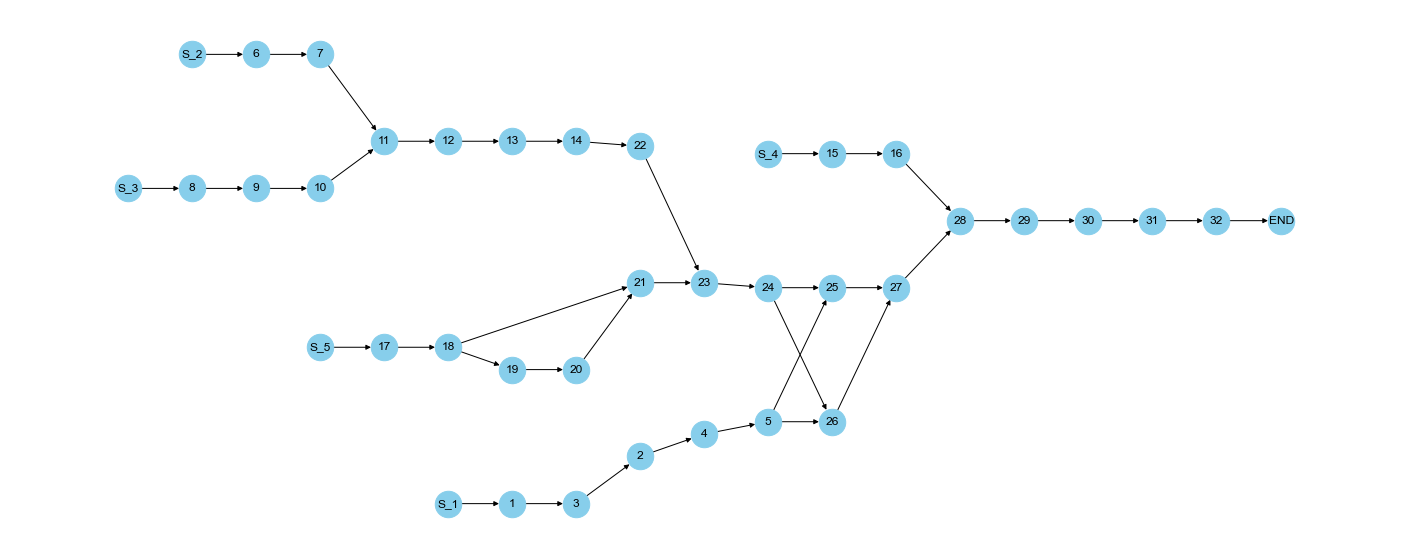

In [14]:
# In[15]:


# Perform Line Balancing
data = import_data(file_path)
graph = precedence_graph(data)
Line_Balance = create_LB_Table(data,graph)
Line_Balance.to_csv('Line_Balance.csv',index=False)
solution = find_feasable_allocation(data,Line_Balance,cycle_time,workstations)
solution.to_csv('Feasable_Solution.csv',index=False)
solution_workstations = max(solution['Workstation'].tolist())



In [15]:
# In[16]:


### CHART THE SIMULATION PERFORMANCE ####


# In[17]:


# Function to convert Simulation Number to Clock Time

def get_simulation_time(sim_min):
    time = '09:00'
    h, m = map(int, time.split(':'))
    init_time = dtt(hour=h, minute=m)
    timdelta = td(minutes=sim_min)
    tmp_datetime = datetime.datetime.combine(datetime.date(1, 1, 1), init_time)
    time2 = (tmp_datetime + timdelta).time()
    return time2.strftime("%I:%M %p")



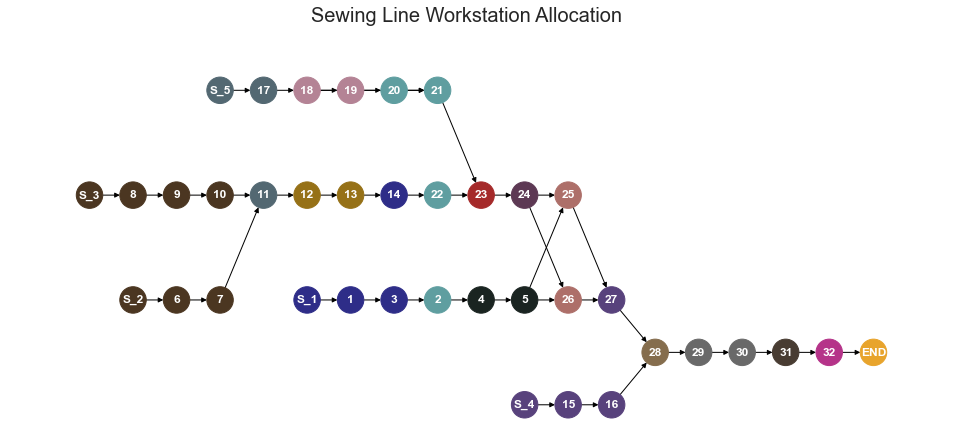

In [16]:
# In[18]:


# Draw the Assembly Line with Color Mapping as per Workstations and Save Output

def save_graph(data_set,workstation, shades):
    
    fig, ax = plt.subplots(figsize=(17, 7))
    fig.suptitle('Sewing Line Workstation Allocation', fontsize=20)
    
    g = nx.DiGraph()
    
    for i, d in data_set.iterrows():
        g.add_node(d[0])
        g.add_edge(d[0],d[7])
    
    colors = [] 
    for node in g:
        for k in range(workstation):
            if node in data_set[data_set['Workstation']==k+1]['Task Number'].values:
                colors.append(shades[k])

    colors.append('#e8a42c')

    pos = nx.drawing.nx_agraph.graphviz_layout(
            g,
            prog='dot',
            args='-Grankdir=LR'
        )
    
    nx.draw(g,with_labels=True,node_size=700, node_color=colors,
            pos = pos,ax=ax, font_color = 'white', font_weight = 'bold')
    
    plt.savefig('Allocated_Ws_hat.png', dpi=300)
    
save_graph(solution,workstations,node_colors)    


In [17]:
# In[19]:


# Class to Create Simulation Charts during intervals

class ClockAndData:
    def __init__(self, canvas, canvas_1, x1, y1, time, current_production, workstations, subplot_dict_p,
                 subplot_dict_q, subplot_dict_w, subplot_dict_wip, cycle_time, allocation, position, ax_graph, takt_time, 
                ct_achieved):
        self.canvas = canvas
        self.canvas_1 = canvas_1
        self.x1 = x1
        self.y1 = y1 - 10
        self.time = time
        self.current_production = current_production
        self.workstations = workstations
        self.subplot_dict_p = subplot_dict_p
        self.subplot_dict_q = subplot_dict_q
        self.subplot_dict_w = subplot_dict_w
        self.subplot_dict_wip = subplot_dict_wip
        self.cycle_time = cycle_time
        self.allocation = allocation
        self.position = position
        self.ax_graph = ax_graph
        self.takt_time = takt_time
        self.ct_achieved = ct_achieved
        canvas_1.create_text(self.x1+500, self.y1, font=("Arial Narrow",16, 'bold'), text= "SEW-MULATOR ENGINE by Optimalytics Business Solutions",anchor=tk.NW, fill='white')
        
    def tick(self,time,production):
        
        self.canvas.delete(self.time)
        x1_start = self.x1 + 50
        self.time = canvas.create_text(x1_start, self.y1, font=("Arial Narrow",14,'bold'), 
                                       text = "Simulation Time : " + str(get_simulation_time(round(time, 1))), anchor = tk.NW,fill='#6C3400')
        
        
        self.canvas.delete(self.takt_time)
        x2_start = x1_start + 400
        self.takt_time = canvas.create_text(x2_start, self.y1, font=("Arial Narrow",14,'bold'), 
                                            text = "Desired Cycle Time : " + str(round(g.takt,2)), anchor = tk.NW,fill='#6C3400')
        
        self.canvas.delete(self.ct_achieved)
        x3_start = x2_start + 400
        achieved = round(g.cycle_data['CT'].mean(),2)
        self.ct_achieved = canvas.create_text(x3_start, self.y1, font=("Arial Narrow",14,'bold'), 
                                            text = "Cycle Time Now: " + str(achieved), anchor = tk.NW,fill='#6C3400')
           
        self.canvas.delete(self.current_production)
        x4_start = x3_start + 400
        self.current_production = canvas.create_text(x4_start, self.y1, font=("Arial Narrow",14,'bold'), text= "ThroughPut : "+ str(production),anchor=tk.NW, fill='#6C3400')
                       
        self.canvas.update()   
        
        # Capture the Production Related Data in the First Tab of Simulation Visualization
        for i in range(self.workstations):
            sub_p = self.subplot_dict_p['a' + str(i)]
            sub_p.cla()
            if i == 0:
                sub_p.set_ylabel('Components Produced (Numbers)')
                
            process = g.finished_rm_plot_data[g.finished_rm_plot_data['Workstation'] == i +1]['Process']
            try:
                finished_rm = g.finished_rm_plot_data[g.finished_rm_plot_data['Workstation'] == i +1]['Finished_RM']
            except:
                finished_rm = [0]
                
            x_lab = list(map(str,process))  
            sub_p.bar(x_lab, finished_rm, color = '#80003A')
            sub_p.set_title('W_%d' %(int(i)+1),fontsize=8)
            sub_p.set_ylim(ymin=0, ymax = g.bundle_size)
            sub_p.set_xticklabels(labels = x_lab,rotation=90)
                   
        data_plot.draw()
        data_plot.flush_events()
        
        # Capture the Operator Lead Time Related Data in the Second Tab of Simulation Visualization
        for i in range(self.workstations):
            sub_p = self.subplot_dict_q['a' + str(i)]
            sub_p.cla()
            if i == 0:
                sub_p.set_ylabel('Average Lead Time')
                
            process = g.que_plot_data[g.que_plot_data['Workstation'] == i +1]['Process']
            try:
                ques = g.que_plot_data[g.que_plot_data['Workstation'] == i +1]['Que']
            except:
                ques = [0]
                
            x_lab = list(map(str,process))      
            sub_p.bar(x_lab, ques, color = '#506432')
            sub_p.set_title('W_%d' %(int(i)+1),fontsize=8)
            sub_p.set_ylim(ymin=0)
            sub_p.set_xticklabels(labels = x_lab,rotation=90)
                   
        data_plot_1.draw()
        data_plot_1.flush_events()
        
        # Capture the Idle Time Related Data in the Third Tab of Simulation Visualization
        for i in range(self.workstations):
            sub_p = self.subplot_dict_w['a' + str(i)]
            sub_p.cla()
            if i == 0:
                sub_p.set_ylabel('Average Idle Time')    
            
            process = g.proc_wait_plot_data[g.proc_wait_plot_data['Workstation'] == i +1]['Process']
            try:
                waiting = g.proc_wait_plot_data[g.proc_wait_plot_data['Workstation'] == i +1]['Wait_Time']
                # print(waiting)
            except:
                waiting = [0]
            x_lab = list(map(str,process))      
            sub_p.bar(x_lab, waiting, color = '#0065A2')
            sub_p.set_title('W_%d' %(int(i)+1),fontsize=8)
            sub_p.set_ylim(ymin=0, ymax = self.cycle_time)
            sub_p.set_xticklabels(labels = x_lab,rotation=90)
            
            
        data_plot_2.draw()
        data_plot_2.flush_events()
        
        # Capture the Components Que Time Related Data in the Fourth Tab of Simulation Visualization
        for i in range(self.workstations):
            sub_p = self.subplot_dict_wip['a' + str(i)]
            sub_p.cla()
            if i == 0:
                sub_p.set_ylabel('Average Que Time')
                
            process = g.wip_plot_data[g.wip_plot_data['Workstation'] == i +1]['Process']
            try:
                wips = g.wip_plot_data[g.wip_plot_data['Workstation'] == i +1]['Wip']
            except:
                wips = [0]
                
            x_lab = list(map(str,process))      
            sub_p.bar(x_lab, wips, color = '#00B0BA')
            sub_p.set_title('W_%d' %(int(i)+1),fontsize=8)
            sub_p.set_ylim(ymin=0)
            sub_p.set_xticklabels(labels = x_lab,rotation=90)
                   
        data_plot_3.draw()
        data_plot_3.flush_events()
        
        avg_idle_time = g.proc_wait_plot_data['Wait_Time'].mean()
        
        for i in range(self.workstations):
            sub_p = self.subplot_dict_w['a' + str(i)]
            sub_p.axhline(y = avg_idle_time, xmin=0, c="black", linewidth=0.5, zorder=0)

        data_plot_2.draw()
        data_plot_2.flush_events()
        
        
        if time >= g.sim_time - 1:
            update_nodes(self.allocation, self.position, self.ax_graph, g.process_data)
            prec_plot.draw()
            prec_plot.flush_events()



In [18]:
# In[20]:


# Draw the Assembly Line with Color Mapping as per Workstations

def allocated_graph(data_set,workstation,ax, shades):
    
    g = nx.DiGraph()
    
    for i, d in data_set.iterrows():
        g.add_node(d[0])
        g.add_edge(d[0],d[7])
    
    colors = [] 
    for node in g:
        for k in range(workstation):
            if node in data_set[data_set['Workstation']==k+1]['Task Number'].values:
                colors.append(shades[k])

    colors.append('#e8a42c')

    pos = nx.drawing.nx_agraph.graphviz_layout(
            g,
            prog='dot',
            args='-Grankdir=LR'
        )
    
    nx.draw(g,with_labels=True,node_size=700, node_color=colors,
            pos = pos,ax=ax, font_color = 'white', font_weight = 'bold')
    
    
    return g, pos, ax



In [19]:
# In[21]:


# Update the Precedence Diagram with Average Idle time at each process
def update_nodes(g, pos, ax, process_data):
    label_dic = {}
    for node in g:
        try:
            avg_wait = str(round(process_data[process_data['Process'] == node]['Idle_Time'].mean(),2))
        except:
            avg_wait = "0"
            
        label_dic[node] = avg_wait
        
    for p in pos:
        yOffSet = 25
        xOffSet = 0

        pos[p] = (pos[p][0]+xOffSet,pos[p][1]+yOffSet)
    
    labelDescr = nx.draw_networkx_labels(g, pos = pos, ax = ax, labels=label_dic, font_size=10)
    
    
    return g



Production Cycle Complete at Time : 20.229999999999997 Total Production : 1 Cycle Time For this Production:  20.229999999999997
Production Cycle Complete at Time : 21.179999999999993 Total Production : 2 Cycle Time For this Production:  0.9499999999999957
Production Cycle Complete at Time : 22.129999999999995 Total Production : 3 Cycle Time For this Production:  0.9500000000000028
Production Cycle Complete at Time : 23.07999999999999 Total Production : 4 Cycle Time For this Production:  0.9499999999999957


KeyboardInterrupt: 

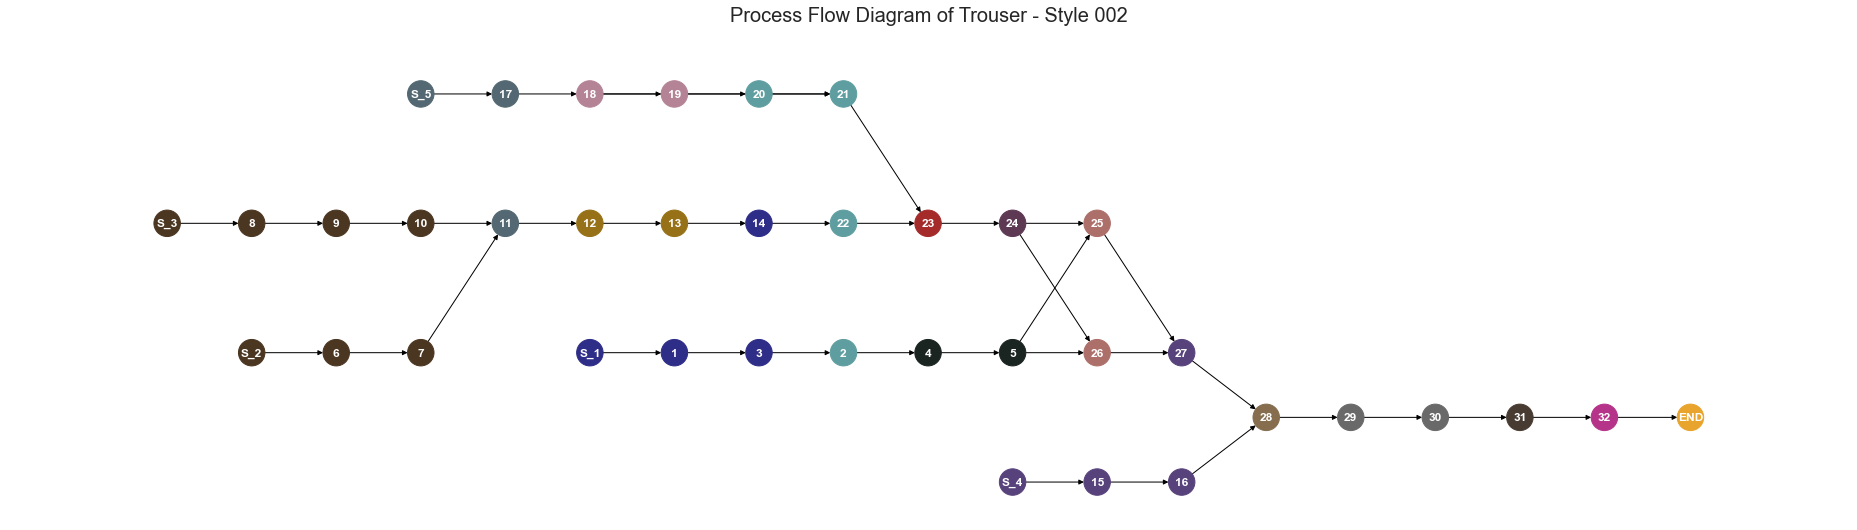

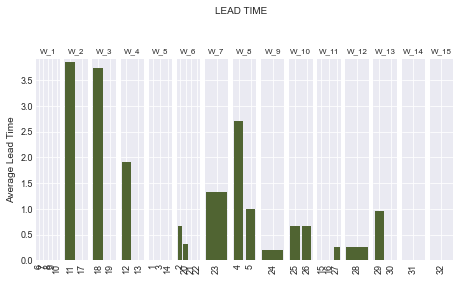

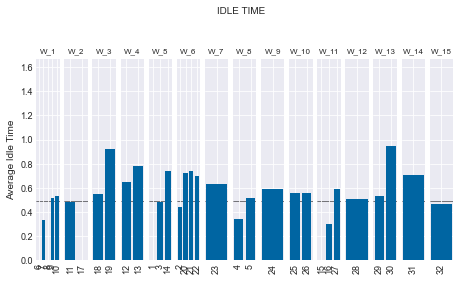

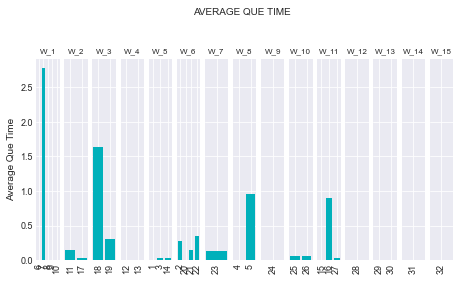

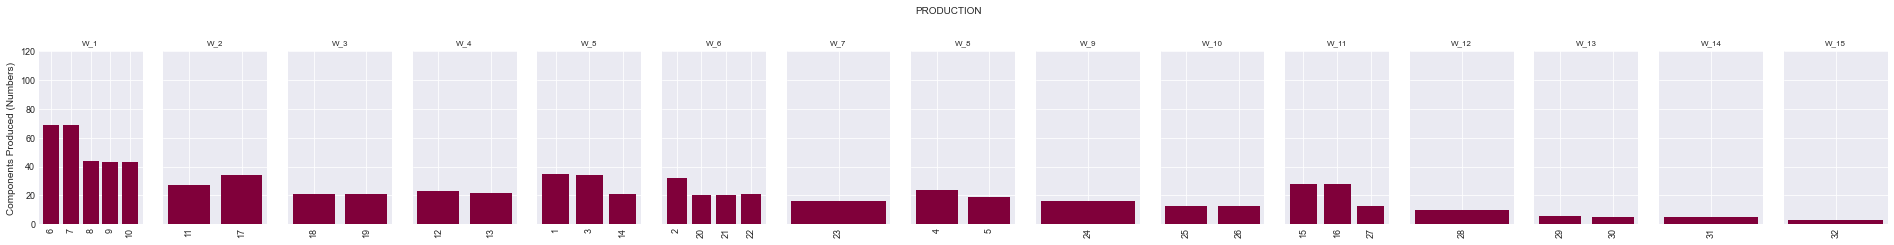

In [20]:

# In[22]:


# Create the Main Window with Plots

main = tk.Tk()
width= main.winfo_screenwidth() 
height= main.winfo_screenheight()
#setting tkinter window size
main.geometry("%dx%d" % (width, height))

main.title('Sewing Line Simulation')

top_frame = tk.Frame(main)
top_frame.pack(side=tk.TOP,expand=True)


company_name = tk.Canvas(main, width = main.winfo_screenwidth(), height = main.winfo_screenheight()*.025, bg = "#696B7E")
company_name.pack(side=tk.TOP, fill=tk.BOTH,expand = True)

canvas = tk.Canvas(main, width = main.winfo_screenwidth(), height = main.winfo_screenheight()*.025, bg = "#FFCD73")
canvas.pack(side=tk.TOP, fill=tk.BOTH,expand = True)

prec_f = plt.figure()
prec_gs = GridSpec(1,1,figure=prec_f)
prec_ax = plt.subplot(prec_gs.new_subplotspec((0,0)))
prec_gs.update(left=0.02,right=0.98,top=0.9,bottom=0.1,wspace=0.2,hspace=0.01)
prec_f.suptitle('Process Flow Diagram of '+ style_name, fontsize=20)
prec_plot = FigureCanvasTkAgg(prec_f, master=main)
prec_plot.get_tk_widget().config(width= main.winfo_screenwidth(),height = main.winfo_screenheight()*.5)
prec_plot.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
allocation, position, ax_graph = allocated_graph(solution,workstations,prec_ax, node_colors)


TAB_CONTROL = ttk.Notebook(main, width = 200, height = 200)
TAB_CONTROL.pack(side=tk.TOP, fill=tk.BOTH,expand = True)
#Tab1
TAB1 = ttk.Frame(TAB_CONTROL)
TAB_CONTROL.add(TAB1, text='Operator Production')
#Tab2
TAB2 = ttk.Frame(TAB_CONTROL)
TAB_CONTROL.add(TAB2, text='Operator Lead Time')
#Tab3
TAB3 = ttk.Frame(TAB_CONTROL)
TAB_CONTROL.add(TAB3, text='Operator Idle Time')
#Tab4
TAB4 = ttk.Frame(TAB_CONTROL)
TAB_CONTROL.add(TAB4, text='Components Que Time')
TAB_CONTROL.pack(expand=1, fill="both")


f = plt.figure()
gs = GridSpec(1,solution_workstations,figure=f)
gs.update(left=0.025,right=0.99,top=0.8,bottom=0.1,wspace=0.2,hspace=0.01)

subplot_dict_p = {}

for col in range(solution_workstations):
    if 'a' + str(col) == 'a0':
        subplot_dict_p['a' + str(col)] = plt.subplot(gs.new_subplotspec((0,col)))
    else:
        subplot_dict_p['a' + str(col)] = plt.subplot(gs.new_subplotspec((0,col)),sharey = subplot_dict_p['a0'])


for ax in range(len(f.get_axes())):
    if ax == 0:
        f.get_axes()[ax].tick_params(bottom=True, labelbottom=True, left=True, labelleft=True,labelsize=9)
    else:
        f.get_axes()[ax].tick_params(bottom=True, labelbottom=True, left=False, labelleft=False,labelsize=9)
        
f.suptitle('PRODUCTION',fontsize=10)
data_plot = FigureCanvasTkAgg(f, master=TAB1)
data_plot.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
        

f_1 = plt.figure()
gs_1 = GridSpec(1,solution_workstations,figure=f_1)
gs_1.update(left=0.025,right=0.99,top=0.8,bottom=0.1,wspace=0.2,hspace=0.01)

subplot_dict_q = {}

for col in range(solution_workstations):
    if 'a' + str(col) == 'a0':
        subplot_dict_q['a' + str(col)] = plt.subplot(gs.new_subplotspec((0,col)))
    else:
        subplot_dict_q['a' + str(col)] = plt.subplot(gs.new_subplotspec((0,col)),sharey = subplot_dict_q['a0'])


for ax in range(len(f_1.get_axes())):
    if ax == 0:
        f_1.get_axes()[ax].tick_params(bottom=True, labelbottom=True, left=True, labelleft=True,labelsize=9)
    else:
        f_1.get_axes()[ax].tick_params(bottom=True, labelbottom=True, left=False, labelleft=False,labelsize=9)
        
f_1.suptitle('LEAD TIME',fontsize=10)
data_plot_1 = FigureCanvasTkAgg(f_1, master=TAB2)
data_plot_1.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
    
    
f_2 = plt.figure()
gs_2 = GridSpec(1,solution_workstations,figure=f_2)
gs_2.update(left=0.025,right=0.99,top=0.8,bottom=0.1,wspace=0.2,hspace=0.01)

subplot_dict_w = {}

for col in range(solution_workstations):
    if 'a' + str(col) == 'a0':
        subplot_dict_w['a' + str(col)] = plt.subplot(gs.new_subplotspec((0,col)))
    else:
        subplot_dict_w['a' + str(col)] = plt.subplot(gs.new_subplotspec((0,col)),sharey = subplot_dict_w['a0'])


for ax in range(len(f_2.get_axes())):
    if ax == 0:
        f_2.get_axes()[ax].tick_params(bottom=True, labelbottom=True, left=True, labelleft=True,labelsize=9)
    else:
        f_2.get_axes()[ax].tick_params(bottom=True, labelbottom=True, left=False, labelleft=False,labelsize=9)
        
f_2.suptitle('IDLE TIME',fontsize=10)
data_plot_2 = FigureCanvasTkAgg(f_2, master=TAB3)
data_plot_2.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
    
    
f_3 = plt.figure()
gs_3 = GridSpec(1,solution_workstations,figure=f_3)
gs_3.update(left=0.025,right=0.99,top=0.8,bottom=0.1,wspace=0.2,hspace=0.01)

subplot_dict_wip = {}

for col in range(solution_workstations):
    if 'a' + str(col) == 'a0':
        subplot_dict_wip['a' + str(col)] = plt.subplot(gs.new_subplotspec((0,col)))
    else:
        subplot_dict_wip['a' + str(col)] = plt.subplot(gs.new_subplotspec((0,col)),sharey = subplot_dict_wip['a0'])


for ax in range(len(f_3.get_axes())):
    if ax == 0:
        f_3.get_axes()[ax].tick_params(bottom=True, labelbottom=True, left=True, labelleft=True,labelsize=9)
    else:
        f_3.get_axes()[ax].tick_params(bottom=True, labelbottom=True, left=False, labelleft=False,labelsize=9)
        
f_3.suptitle('AVERAGE QUE TIME',fontsize=10)
data_plot_3 = FigureCanvasTkAgg(f_3, master=TAB4)
data_plot_3.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
    
    
clock = ClockAndData(canvas, company_name, (main.winfo_screenwidth()*.05)/2, (main.winfo_screenheight()*.05)/2, 0, 0, solution_workstations, subplot_dict_p,
                    subplot_dict_q, subplot_dict_w, subplot_dict_wip, cycle_time, allocation, position, ax_graph, takt_time, 0)


# In[ ]:


# Start Assembly Line Simulation
line = Assembly_Line(file_path, solution, Workstation, data)
line.run()
main.mainloop()

